In [18]:
from act.cell_model import TargetCell, TrainCell
from act.simulator import Simulator
from act.act_types import SimulationParameters

### 1. Generate target data

In [19]:
# Init the cell
target_cell = TargetCell(
    hoc_file = "/home/mwsrgf/proj/ACT/data/Burster/Izhikevich_p307_orig/template.hoc",
    cell_name = "Burster_Izh",
    g_names = ["gbar_nap", "gkdrbar_kdr", "glbar_leak"]
)

In [20]:
# Simulate a voltage trace
simulator = Simulator()
simulator.submit_job(
    target_cell,
    SimulationParameters(
        sim_name = "target1",
        h_v_init = -70, # (mV)
        h_tstop = 300,  # (ms)
        h_dt = 0.01, # (ms)
        h_celsius = 37, # (deg C)
        CI = {
            "type": "constant",
            "amp": 10,
            "dur": 290,
            "delay": 10
        }
    )
)
# simulator.submit_job(...)
# simulator.submit_job(...)

In [23]:
# Run
simulator.run("/home/mwsrgf/proj/ACT/data/Burster/Izhikevich_p307_orig/modfiles")

Total number of jobs: 1
Total number of proccessors: 192


FileExistsError: [Errno 17] File exists: 'model/target1'

### 2. Generate simulated data

In [5]:
# Init the cell
train_cell = TrainCell(
    hoc_file = "/Users/vladimiromelyusik/ACT/data/Burster/Izhikevich_p307_orig/template.hoc",
    cell_name = "Burster_Izh",
    g_names = ["gbar_nap", "gkdrbar_kdr", "glbar_leak"]
)

In [6]:
# Predict passive properties
# ...

In [7]:
# Simulate a voltage trace
simulator = Simulator()

# Set parameters from the grid
train_cell.set_g(["gbar_nap", "gkdrbar_kdr"], [0.01, 0.02])

simulator.submit_job(
    train_cell, 
    SimulationParameters(
        sim_name = "train1",
        h_v_init = -70, # (mV)
        h_tstop = 300,  # (ms)
        h_dt = 0.01, # (ms)
        h_celsius = 37, # (deg C)
        CI = {
            "type": "constant",
            "amp": 10,
            "dur": 290,
            "delay": 10
        }
    )
)
# simulator.submit_job(...)
# simulator.submit_job(...)

In [8]:
# Run
simulator.run("/Users/vladimiromelyusik/ACT/data/Burster/Izhikevich_p307_orig/modfiles")

Total number of jobs: 1
Total number of proccessors: 8


In [ ]:
# MatchFilter will go over saved data and create a dataset of the traces that match,
# deleting others

## 3. Train the model

In [42]:
import numpy as np
from act.DataProcessor import DataProcessor

dataset = np.load("data.npy")


def get_g(sample):
    g = sample[:, 2]
    return g[~np.isnan(g)]

print(dataset.shape)


V = dataset[:,:,0]
I = dataset[:,:,1]
g = get_g(dataset)
#print(g)
print(V)

dataprocessor = DataProcessor()
#dataprocessor.get_summary_features()

/home/mwsrgf/act-venv/lib64/python3.9/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)
--No graphics will be displayed.


(500, 5000, 3)
[[-0.08561921 -0.89690847 -0.74421393 ... -0.34045334  0.69870242
   0.52632264]
 [-0.27747017  0.15124016 -0.03834683 ...  1.55188582 -1.30490494
  -1.75531461]
 [-0.17651299 -0.40669783 -0.5560327  ...  0.58710649  1.49410355
  -1.26829783]
 ...
 [ 0.05815759 -1.88348629 -0.86419448 ... -1.05243841 -0.8059254
   0.00839816]
 [-1.29335766 -0.16560283 -1.56611188 ... -1.00569988  0.81951197
   0.80382599]
 [ 0.03155482  0.62277788 -0.16383417 ... -1.87504838 -0.09399635
   0.86367439]]


In [57]:
import torch
def extract_spike_features(V: torch.Tensor, spike_threshold=0, n_spikes=20):
    # Get the number of threshold crossings
    threshold_crossings = torch.diff(V > spike_threshold, dim=1)

    # Get the number of spikes
    num_spikes = torch.round(torch.sum(threshold_crossings, dim=1) * 0.5)

    # Get the interspike times
    interspike_times = torch.zeros((V.shape[0], 1))
    for i in range(threshold_crossings.shape[0]):
        interspike_times[i, :] = torch.mean(
            torch.diff(
                torch.arange(threshold_crossings.shape[1])[threshold_crossings[i, :]]
            ).float()
        )
    interspike_times[torch.isnan(interspike_times)] = 0

    
    first_n_spikes = torch.zeros((V.shape[0], n_spikes)) * V.shape[1]
    avg_spike_min = torch.zeros((V.shape[0], 1))
    avg_spike_max = torch.zeros((V.shape[0], 1))
    for i in range(threshold_crossings.shape[0]):
        threshold_crossing_times = torch.arange(threshold_crossings.shape[1])[
            threshold_crossings[i, :]
        ]
        spike_times = []
        spike_mins = []
        spike_maxes = []
        for j in range(0, threshold_crossing_times.shape[0], 2):
            spike_times.append(threshold_crossing_times[j])
            ind = threshold_crossing_times[j : j + 2].cpu().tolist()
            end_ind = ind[1] if len(ind) == 2 else V.shape[1]
            spike_maxes.append(
                V[i][max(0, ind[0] - 1) : min(end_ind + 5, V.shape[1])].max()
            )
            spike_mins.append(
                V[i][max(0, ind[0] - 1) : min(end_ind + 5, V.shape[1])].min()
            )
        first_n_spikes[i][: min(n_spikes, len(spike_times))] = torch.tensor(
            spike_times
        ).flatten()[: min(n_spikes, len(spike_times))]
        avg_spike_max[i] = torch.mean(torch.tensor(spike_maxes).flatten())
        avg_spike_min[i] = torch.mean(torch.tensor(spike_mins).flatten())
        first_n_spikes_scaled = (
            first_n_spikes / V.shape[1]
        )  # may be good to return this
    return num_spikes, interspike_times, first_n_spikes_scaled, avg_spike_min, avg_spike_max

    

tensor([[-0.0650, -0.0645, -0.0640,  ..., -0.0636, -0.0636, -0.0636]],
       dtype=torch.float64)
tensor([12.])
tensor([[415.5218]])
tensor([[0.0076, 0.1024, 0.1890, 0.2748, 0.3603, 0.4458, 0.5311, 0.6166, 0.7021,
         0.7876, 0.8730, 0.9585, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000]])
tensor([[0.0113]])
tensor([[-0.0020]])


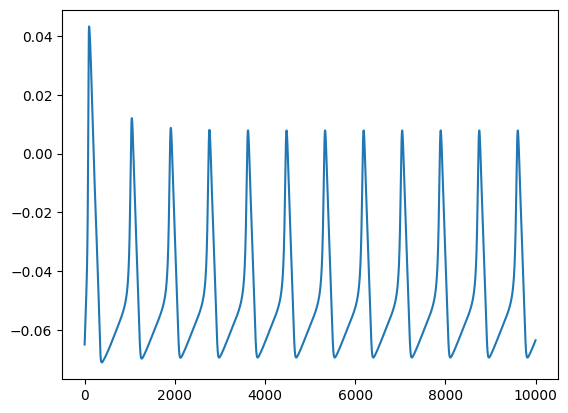

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import torch
test_trace = np.load("test_trace.npy")
trace = []
for i in test_trace:
    i = i/1000
    trace.append(i)


trace = torch.tensor(trace).unsqueeze(0)


print(trace)

# Print the shape to confirm it's now a 2D tensor
#print(trace_2d.shape)

plt.plot(trace[0].cpu().numpy())


(   num_spikes_simulated,
    simulated_interspike_times,
    first_n_spikes, 
    avg_spike_min,
    avg_spike_max
) = extract_spike_features(trace)

print(num_spikes_simulated)
print(simulated_interspike_times)
print(first_n_spikes)
print(avg_spike_max)
print(avg_spike_min)

torch.Size([1, 10000])
tensor([[False, False, False,  ..., False, False, False]])


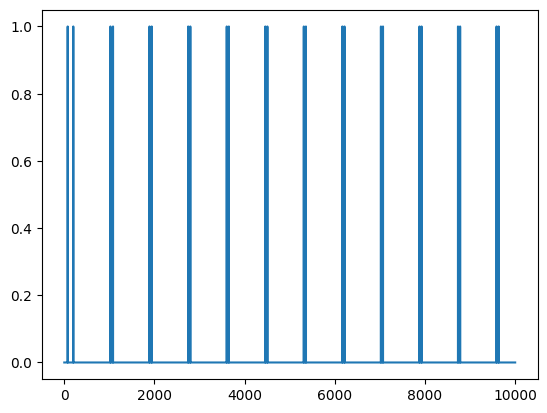

In [51]:
# Get the number of threshold crossings
spike_threshold = 0
threshold_crossings = torch.diff(trace > spike_threshold, dim=1)
print(threshold_crossings.shape)
print(threshold_crossings)
plt.plot(threshold_crossings[0].cpu().numpy())


#print(num_spikes_simulated)
#print(simulated_interspike_times)
#print(first_n_spikes)
#print(avg_spike_max)
#print(avg_spike_min)

In [55]:
num_spikes = torch.round(torch.sum(threshold_crossings, dim=1) * 0.5)
print(num_spikes[0].cpu().numpy())
print(num_spikes.shape)
#plt.plot(num_spikes.cpu().numpy())

12.0
torch.Size([1])


torch.Size([1, 101])


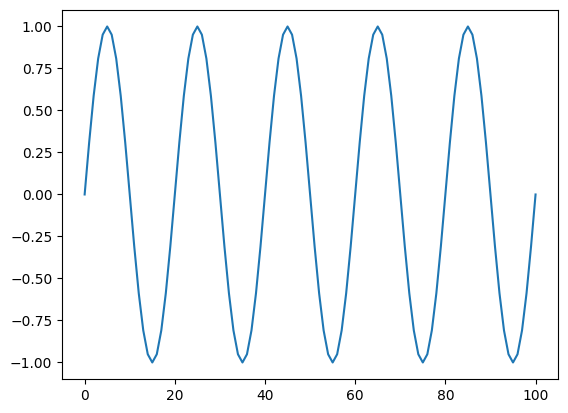

Comparison result:
 tensor([[False, False,  True,  True,  True,  True,  True,  True,  True, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False,  True,  True,  True,  True,  True,  True,  True, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False,  True,  True,  True,  True,  True,  True,  True, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False,  True,  True,  True,  True,  True,  True,  True, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False,  True,  True,  True,  True,  True,  True,  True, False,
         False, False, False, False, False, False, False, False, False, False,
         False]])
Diff result:
 tensor([[False,  True, False, False, False, False, False, False,  True, False,
         False, False, False, False, False, False, False, False, False, False,


In [20]:
import torch
import matplotlib.pyplot as plt

# Simulate a 2D tensor with voltage values over time
time_steps = 101
num_traces = 1
trace_2d = torch.sin(torch.linspace(0, 10 * torch.pi, time_steps)).unsqueeze(0)

print(trace_2d.shape)
# Plot to visualize
plt.plot(trace_2d[0].numpy())
plt.show()

# Set a spike threshold
spike_threshold = 0.5

# Comparison operation
comparison = trace_2d > spike_threshold
print("Comparison result:\n", comparison)

# Differentiation operation
diff_result = torch.diff(comparison, dim=1)
print("Diff result:\n", diff_result)

# Explicit differentiation (if needed)
diff_result_explicit = comparison[:, 1:].int() - comparison[:, :-1].int()
print("Explicit Diff result:\n", diff_result_explicit)